# **1) DATA**

## **1.1 Import Data**

In [ ]:
import json 
import csv 
import io
import pandas as pd

In [ ]:
#importing file titled "dataset_sentiment_analysis.csv"
from google.colab import files
uploaded = files.upload()

Saving dataset_sentiment_analysis.csv to dataset_sentiment_analysis.csv


In [ ]:
df = pd.read_csv(io.StringIO(uploaded.get('dataset_sentiment_analysis.csv').decode('utf-8')))
df.head()

,rating,quarter,traveller_type,price_per_night,Total,Cluster,review_text,raw_review_text
0,9.0,1,Solo traveller,119,1,1,"none,\n\nRoom, location, breakfast - everythin...","<p class=""review_neg ""><svg aria-label=""Negati..."
1,10.0,1,Solo traveller,145,2,2,Elevator isn't great. I think there is a small...,"<p class=""review_neg ""><svg aria-label=""Negati..."
2,10.0,2,Solo traveller,190,0,0,Very comfortable beds and the best bath in any...,"<p class=""review_pos ""><svg aria-label=""Positi..."
3,1.0,1,Solo traveller,158,2,2,17°C in the room!!!!,"<p class=""review_neg ""><svg aria-label=""Negati..."
4,8.3,2,Solo traveller,99,1,1,"Arrived at 22.30 hrs. Bar was closed. ,\n\nCos...","<p class=""review_neg ""><svg aria-label=""Negati..."


## **1.2 Finalized Dataset**

In [ ]:
# get columns necessary for sentiment analysis and text exploration
df_review = df[['review_text', 'Cluster']]
# remove rows withough review
df_review = df_review[df_review.review_text != "There are no comments available for this review"]
df_review.head()

,review_text,Cluster
0,"none,\n\nRoom, location, breakfast - everythin...",1
1,Elevator isn't great. I think there is a small...,2
2,Very comfortable beds and the best bath in any...,0
3,17°C in the room!!!!,2
4,"Arrived at 22.30 hrs. Bar was closed. ,\n\nCos...",1


## **1.3 Pre-process Reviews** 

### *Import necessary packages & Define useful functions*

In [ ]:
import pandas as pd
import re
import nltk
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from nltk.tokenize import WhitespaceTokenizer
import string
from string import punctuation
!pip install autocorrect
from autocorrect import Speller
check = Speller(lang = 'en')

     |████████████████████████████████| 622 kB 29.0 MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.5.0-py3-none-any.whl size=621851 sha256=08b25925df8ffa8385f9f166b771a3d7981c1980466ddde4f5fb30dc1a2e9bc5
  Stored in directory: /root/.cache/pip/wheels/3d/8e/bd/f6fd900a056a031bf710a00bca338d86f43b83f0c25ab5242f
Successfully built autocorrect


In [ ]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('brown')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
# basic text cleaning
def clean_text(text):
    # remove '\n' present in the raw reviews
    text = text.replace('\n', '')
    # lower text
    text = text.lower()
    # spelling error check
    text = [check(word) for word in text.split(" ")]
    text = " ".join(text)
    return text

In [ ]:
def clean_text_for_sentiment(text):
    # tokenize text and split by puncutation
    r = re.compile(r'[\s{}]+'.format(re.escape(punctuation)))
    text = [word.strip(" ") for word in r.split(text)]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags] 
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

### **1.3.1 Basic Clean Reviews**

In [ ]:
df_review['review_text'] = df_review['review_text'].apply(lambda x: clean_text(x))
df_review.head()

,review_text,Cluster
0,"none,room, location, breakfast - everything ac...",1
1,elevator isn't great. i think there is a small...,2
2,very comfortable beds and the best bath in any...,0
3,17°c in the room!!!!,2
4,"arrived at 22.30 hrs. bar was closed. ,copy mo...",1


### **1.3.2 Split Review**

In [ ]:
# split review_text to sentences based on tokenize function
df_review['split_review_text'] = df_review['review_text'].apply(sent_tokenize)
df_review.head()

,review_text,Cluster,split_review_text
0,"none,room, location, breakfast - everything ac...",1,"[none,room, location, breakfast - everything a..."
1,elevator isn't great. i think there is a small...,2,"[elevator isn't great., i think there is a sma..."
2,very comfortable beds and the best bath in any...,0,[very comfortable beds and the best bath in an...
3,17°c in the room!!!!,2,"[17°c in the room!!!, !]"
4,"arrived at 22.30 hrs. bar was closed. ,copy mo...",1,"[arrived at 22.30 hrs., bar was closed., ,copy..."


### **1.3.3 Clean Split Reviews for Sentiment Analysis**

In [ ]:
# Further clean split reviews for sentiment analysis
df_review['split_review_text_clean'] = df_review['split_review_text'].apply(lambda split_review: [clean_text_for_sentiment(sentence) for sentence in split_review])
df_review.head()

,review_text,Cluster,split_review_text,split_review_text_clean
0,"none,room, location, breakfast - everything ac...",1,"[none,room, location, breakfast - everything a...",[none room location breakfast everything accor...
1,elevator isn't great. i think there is a small...,2,"[elevator isn't great., i think there is a sma...","[elevator great, think small bar downstairs wo..."
2,very comfortable beds and the best bath in any...,0,[very comfortable beds and the best bath in an...,"[comfortable bed best bath hotel i’ve stay, ea..."
3,17°c in the room!!!!,2,"[17°c in the room!!!, !]","[room, ]"
4,"arrived at 22.30 hrs. bar was closed. ,copy mo...",1,"[arrived at 22.30 hrs., bar was closed., ,copy...","[arrive hr, bar close, copy modern room bathro..."


# **2) SENTIMENT ANALYSIS**

### *Import necessary packages & Define useful functions*

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
# classify reviews to positive and negative
def analysis(score):
    if score < 0:
        return 'Negative'
    else:
        return 'Positive'

In [ ]:
# get polarity score for each sentence in each review
def list_polarity_score(sentences):
    result = []
    for sentence in sentences:
        result.append(sid.polarity_scores(sentence))
    return result

In [ ]:
# classify sentences to positive or negative
def list_analysis(lst):
    result = []
    for score in lst:
        result.append(analysis(score['compound']))
    return result

## **2.1 Sentiment Analysis for Split Review**

In [ ]:
# sentiment analysis associated with each sentence in reviews
df_review['sentences_sentiments'] = df_review["split_review_text_clean"].apply(lambda x : list_polarity_score(x))
df_review['sentences_sentiments'] = df_review['sentences_sentiments'].apply(list_analysis)
df_review.head()

,review_text,Cluster,split_review_text,split_review_text_clean,sentences_sentiments
0,"none,room, location, breakfast - everything ac...",1,"[none,room, location, breakfast - everything a...",[none room location breakfast everything accor...,[Positive]
1,elevator isn't great. i think there is a small...,2,"[elevator isn't great., i think there is a sma...","[elevator great, think small bar downstairs wo...","[Positive, Positive, Positive, Positive, Posit..."
2,very comfortable beds and the best bath in any...,0,[very comfortable beds and the best bath in an...,"[comfortable bed best bath hotel i’ve stay, ea...","[Positive, Positive, Positive, Positive, Posit..."
3,17°c in the room!!!!,2,"[17°c in the room!!!, !]","[room, ]","[Positive, Positive]"
4,"arrived at 22.30 hrs. bar was closed. ,copy mo...",1,"[arrived at 22.30 hrs., bar was closed., ,copy...","[arrive hr, bar close, copy modern room bathro...","[Positive, Positive, Positive, Positive]"


# **3) USEFUL COMMON WORDS**

### *Import necessary packages & Define useful functions*

In [ ]:
# get count and desc of words based on their sentiment
def classify_reviews(word, reviews, text):
    if (word not in reviews):
        reviews[word] = {}
        reviews[word]['count'] = 1
        reviews[word]['desc'] = [text]
    else:
        reviews[word]['count'] += 1
        reviews[word]['desc'].append(text)
    return reviews

In [ ]:
# get count of most useful words across topics in the cluster
def get_common_words(df_review_cluster, words_cluster):
    reviews = [{}, {}]
    for index, row in df_review_cluster.iterrows():
        texts = row['split_review_text']
        sentiments = row['sentences_sentiments']
        for i in range(len(texts)):
            text = texts[i]
            sentiment = sentiments[i]
            for word in set(words_cluster):
                if (word in text):
                    if (sentiment == 'Positive'):
                        reviews[0] = classify_reviews(word, reviews[0], text) 
                    else: #this is the case when sentiment == 'Negative'
                        reviews[1] = classify_reviews(word, reviews[1], text)
    return reviews

In [ ]:
# remove word that appeared in multiple topics and/or may not be useful
def remove_word(words_cluster, words):
    for i in range(len(words)):
        for word in words[i]:
            if (word in words_cluster[i]):
                words_cluster[i].remove(word)
    return words_cluster

In [ ]:
# create dataframe of most useful words in cluster along with positive count, positive descriptions, negative count, negative descriptions of each word
def create_df_common_words(common_words_cluster):
    # create positive and negative common words dataframe
    df_pos_cluster = pd.DataFrame.from_dict(common_words_cluster[0], orient='index').reset_index()
    df_neg_cluster = pd.DataFrame.from_dict(common_words_cluster[1], orient='index').reset_index()
  
    # combine positive and negative common words by word
    df_common_words_cluster = pd.merge(df_pos_cluster, df_neg_cluster, left_on = 'index', right_on = 'index')
  
    # rename dataframe column names
    df_common_words_cluster.columns = ['word', 'pos_count', 'pos_desc', 'neg_count', 'neg_desc']
  
    # get total count of words
    df_common_words_cluster['total_count'] = df_common_words_cluster['pos_count'] + df_common_words_cluster['neg_count']
  
    # sort dataframe based on total count
    df_common_words_cluster = df_common_words_cluster.sort_values(by=['total_count'], ascending = False)

    # remove adjective words
    df_common_words_cluster = df_common_words_cluster[df_common_words_cluster['word'].apply(lambda word: nltk.pos_tag(nltk.word_tokenize(word))[0][1] != 'JJ')].reset_index(drop = True)

    return df_common_words_cluster

In [ ]:
# initialize counts for topics dict
def initialize_count_for_topics(topic_cluster):
    counts_for_topics = {}
    for i in range(6): #6 because we have 6 topics in each cluster
        topic = topic_cluster.columns[i]
        counts_for_topics[topic] = {"positive": 0, "negative": 0}
    return counts_for_topics

In [ ]:
# get topics and their respective count from each word's description
def get_topics_and_count(df_common_words, word_cluster, topic_cluster):
    topics = []
    counts_for_topics = initialize_count_for_topics(topic_cluster)
    for index, row in df_common_words.iterrows():
        word, pos_count, neg_count = row['word'], row['pos_count'], row['neg_count']
        temp = []
        for i in range(6): #6 because we have 6 topics in each cluster
            words = word_cluster[i]
            topic = topic_cluster.columns[i] 
            if (word in words):
                counts_for_topics[topic]["positive"] += pos_count
                counts_for_topics[topic]["negative"] += neg_count
                temp.append(topic)
        topics.append(temp)
    return [counts_for_topics, topics]

## **3.1 Cluster 0**

In [ ]:
#importing file titled "cluster0_top20.csv"
from google.colab import files
uploaded = files.upload()

Saving cluster0_top20.csv to cluster0_top20.csv


In [ ]:
# filter reviews for people in cluster 0
df_review_cluster_0 = df_review.loc[df['Cluster'] == 0].reset_index(drop = True)

In [ ]:
# read in topics in clusters
topic_cluster_0 = pd.read_csv(io.BytesIO(uploaded['cluster0_top20.csv']), header = 0, encoding = "unicode_escape")
words_cluster_0 = topic_cluster_0.transpose().values.tolist()

# remove word(s) that appeared in more than 1 topic and/or may not be useful
to_remove_0 = [["lot", "good"], 
              ["good"],
              ["great", "extremely", "super", "nice"],
              ["didnt", "high"],
              ["good", "nice", "excellent", "great"],
              ["excellent", "good", "bite", "great", "breakfast"]]
words_cluster_0 = remove_word(words_cluster_0, to_remove_0)

# get most useful words across topic in the cluster
combined_words_cluster_0 = sum(words_cluster_0, [])

# get most common useful words in the cluster
common_words_cluster_0 = get_common_words(df_review_cluster_0, combined_words_cluster_0)

In [ ]:
# create dataframe for useful common words in cluster
df_common_words_cluster_0 = create_df_common_words(common_words_cluster_0)

# get topics and and their count
topics_count_0 = get_topics_and_count(df_common_words_cluster_0, words_cluster_0, topic_cluster_0)

# add topics column
df_common_words_cluster_0["topics"] = topics_count_0[1]
df_common_words_cluster_0.head()

,word,pos_count,pos_desc,neg_count,neg_desc,total_count,topics
0,room,104,[enjoyed the option to have breakfast and even...,8,[my partner was with me next to the phone in t...,112,"[Room amenities, Hotel amenities/vicinity, Sta..."
1,hotel,81,[very comfortable beds and the best bath in an...,10,[we stayed on a side of the hotel with a very ...,91,"[Room amenities, Staff/service, General commen..."
2,breakfast,59,[enjoyed the option to have breakfast and even...,3,[we didn't have the hotel's breakfast preferri...,62,"[Hotel amenities/vicinity, Food related]"
3,min,40,[just a real minor thing: really small selecti...,5,[we didn't work this out and spent several min...,45,[Location]
4,clean,42,"[everything was great, but the breakfast quali...",2,"[nothing ,clean with good facilities., nothing...",44,"[Room amenities, Staff/service, Food related]"


In [ ]:
df_topic_sentiment_cluster_0 = pd.DataFrame.from_dict(topics_count_0[0], orient='index').reset_index()
df_topic_sentiment_cluster_0

,index,positive,negative
0,Room amenities,362,40
1,Hotel amenities/vicinity,231,27
2,Staff/service,290,28
3,General comments,159,36
4,Food related,372,30
5,Location,226,27


## **3.2 Cluster 1**

In [ ]:
#importing file titled "cluster1_top20.csv"
from google.colab import files
uploaded = files.upload()

Saving cluster1_top20.csv to cluster1_top20.csv


In [ ]:
# filter reviews for people in cluster 1
df_review_cluster_1 = df_review.loc[df['Cluster'] == 1].reset_index(drop = True)

In [ ]:
# read in topics in clusters
topic_cluster_1 = pd.read_csv(io.BytesIO(uploaded['cluster1_top20.csv']), header = 0, encoding = "unicode_escape")
words_cluster_1 = topic_cluster_1.transpose().values.tolist()

# remove word(s) that appeared in more than 1 topic and/or may not be useful
to_remove_1 = [["great", "perfect", "good"],
               ["good", "great", "wasn"], 
               ["didn", "lot"],
               ["good", "nice"], 
               ["bite", "good", "great", "bad"], 
               ["good", "nice", "excellent"]]
words_cluster_1 = remove_word(words_cluster_1, to_remove_1)

# get most useful words across topic in the cluster
combined_words_cluster_1 = sum(words_cluster_1, [])

# get most common useful words in the cluster
common_words_cluster_1 = get_common_words(df_review_cluster_1, combined_words_cluster_1)

In [ ]:
# create dataframe for useful common words in cluster
df_common_words_cluster_1 = create_df_common_words(common_words_cluster_1)

# get topics and and their count
topics_count_1 = get_topics_and_count(df_common_words_cluster_1, words_cluster_1, topic_cluster_1)

df_common_words_cluster_1["topics"] = topics_count_1[1]
df_common_words_cluster_1.head()

,word,pos_count,pos_desc,neg_count,neg_desc,total_count,topics
0,room,202,"[none,room, location, breakfast - everything a...",23,"[there was a lot of dirt in the room., the fir...",225,"[Location, Food related, Room amenities, Gener..."
1,hotel,96,"[amazing hotel crew!, i̇t was not enough.,the ...",16,"[it’s not close to the station, also the area ...",112,"[Location, Food related, Hotel amenities/vicin..."
2,break,87,"[none,room, location, breakfast - everything a...",8,"[nothing to add.,i had a great breakfast., the...",95,[Room amenities]
3,breakfast,86,"[none,room, location, breakfast - everything a...",8,"[nothing to add.,i had a great breakfast., the...",94,"[Location, Food related, Staff/service]"
4,location,79,"[none,room, location, breakfast - everything a...",10,[the location was near the train station but i...,89,"[Location, Food related, Hotel amenities/vicin..."


In [ ]:
df_topic_sentiment_cluster_1 = pd.DataFrame.from_dict(topics_count_1[0], orient='index').reset_index()
df_topic_sentiment_cluster_1

,index,positive,negative
0,Location,578,85
1,Food related,751,80
2,Hotel amenities/vicinity,386,61
3,Room amenities,618,84
4,General comments,428,54
5,Staff/service,557,65


## **3.3 Cluster 2**

In [ ]:
#importing file titled "cluster2_top20.csv"
from google.colab import files
uploaded = files.upload()

Saving cluster2_top20.csv to cluster2_top20.csv


In [ ]:
# filter reviews for people in cluster 2
df_review_cluster_2 = df_review.loc[df['Cluster'] == 2].reset_index(drop = True)

In [ ]:
# read in topics in clusters
topic_cluster_2 = pd.read_csv(io.BytesIO(uploaded['cluster2_top20.csv']), header = 0, encoding = "unicode_escape")
words_cluster_2 = topic_cluster_2.transpose().values.tolist()

# remove word(s) that appeared in more than 1 topic and/or may not be useful
to_remove_2 = [["good", "nice", "bite"],
               ["super", "good", "great"], 
               ["good"],
               ["good", "great", "excellent"], 
               ["good", "nice", "bite", "fine"], 
               ["didnt", "nice"]]
words_cluster_2 = remove_word(words_cluster_2, to_remove_2)

# get most useful words across topic in the cluster
combined_words_cluster_2 = sum(words_cluster_2, [])

# get most common useful words in the cluster
common_words_cluster_2 = get_common_words(df_review_cluster_2, combined_words_cluster_2)

In [ ]:
# create dataframe for useful common words in cluster
df_common_words_cluster_2 = create_df_common_words(common_words_cluster_2)

# get topics and and their count
topics_count_2 = get_topics_and_count(df_common_words_cluster_2, words_cluster_2, topic_cluster_2)

df_common_words_cluster_2["topics"] = topics_count_2[1]
df_common_words_cluster_2.head()

,word,pos_count,pos_desc,neg_count,neg_desc,total_count,topics
0,room,251,[i think there is a small bar downstairs but i...,30,"[empty fridge in the room., very noisy room ne...",281,"[Food related, Staff/service, Hotel amenities/..."
1,hotel,158,[ask for a room at the back if a light sleeper...,9,[didnt like the fact that i paid hotel 45 days...,167,"[Food related, Staff/service, Location, Hotel ..."
2,staff,142,"[good location and very good staff, the staff ...",3,[none of the staff were confident enough to te...,145,"[Food related, Staff/service]"
3,breakfast,117,"[cant think of anything !,did not have breakfa...",13,[none of the staff were confident enough to te...,130,"[Food related, Staff/service, Hotel amenities/..."
4,location,112,"[also a minute or two walk to mark, i can't im...",12,[no bed sheet change for 5 days.poor bar servi...,124,"[Staff/service, Location, Hotel amenities/vici..."


In [ ]:
df_topic_sentiment_cluster_2 = pd.DataFrame.from_dict(topics_count_2[0], orient='index').reset_index()
df_topic_sentiment_cluster_2

,index,positive,negative
0,Food related,950,90
1,Staff/service,977,84
2,Location,572,45
3,Hotel amenities/vicinity,795,79
4,Room amenities,567,70
5,General comments,852,104


## **3.4 Cluster 3**

In [ ]:
#importing file titled "cluster3_top10.csv"
from google.colab import files
uploaded = files.upload()

Saving cluster3_top10.csv to cluster3_top10.csv


In [ ]:
# filter reviews for people in cluster 3
df_review_cluster_3 = df_review.loc[df['Cluster'] == 3].reset_index(drop = True)

In [ ]:
# read in topics in clusters. The topics in this cluster are unlabelled because of the lack of words in each component from the LDA algorithm.
topic_cluster_3 = pd.read_csv(io.BytesIO(uploaded['cluster3_top10.csv']), header = 0, encoding = "unicode_escape")
words_cluster_3 = topic_cluster_3.transpose().values.tolist()

# remove word(s) that appeared on more than 1 topic and/or may not be useful
to_remove_3 = [["good"],
               ["good", "excellent", "fantastic"], 
               ["good", "nice", "extremely"],
               [""], 
               ["great"], 
               ["good", "perfect", "bite"]]
words_cluster_3 = remove_word(words_cluster_3, to_remove_3)

# get most useful words across topic in the cluster
combined_words_cluster_3 = sum(words_cluster_3, [])

# get most common useful words in the cluster cluster
common_words_cluster_3 = get_common_words(df_review_cluster_3, combined_words_cluster_3)

In [ ]:
# create dataframe for useful common words in cluster
df_common_words_cluster_3 = create_df_common_words(common_words_cluster_3)

# get topics and and their count
topics_count_3 = get_topics_and_count(df_common_words_cluster_3, words_cluster_3, topic_cluster_3)

df_common_words_cluster_3["topics"] = topics_count_3[1]
df_common_words_cluster_3.head()

,word,pos_count,pos_desc,neg_count,neg_desc,total_count,topics
0,room,33,"[the bar prices were very expensive.,the room ...",5,"[nothing,comfort of the room, no coffee facili...",38,"[Hotel amenities/vicinity, General comments, R..."
1,staff,36,"[the staff were efficient and friendly., the c...",1,"[nothing ,amazing place, amazing position and ...",37,"[General comments, Staff/service, Location]"
2,location,32,"[great location, couple minutes from the main ...",2,"[nothing,great location, very good house clean...",34,"[Location, Food related]"
3,service,15,"[the bar prices were very expensive.,the room ...",3,[the breakfast was a bit disappointing : the 1...,18,"[Hotel amenities/vicinity, Food related]"
4,bed,14,"[comfortable bed, great location, not much to ...",2,[a broken label in a suite is not what you exp...,16,"[Room amenities, Location]"


In [ ]:
df_topic_sentiment_cluster_3 = pd.DataFrame.from_dict(topics_count_3[0], orient='index').reset_index()
df_topic_sentiment_cluster_3

,index,positive,negative
0,Hotel amenities/vicinity,57,10
1,General comments,76,7
2,Staff/service,42,2
3,Room amenities,50,8
4,Location,108,9
5,Food related,96,14


# **4) VISUALISATION**

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from itertools import chain

## **4.1 Cluster 0**

Text(0.5, 1.0, 'Common Words in Cluster 0')

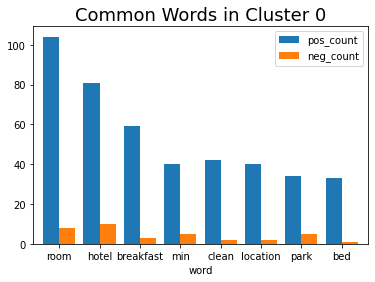

In [ ]:
# plot common words in the cluster
df_common_words_cluster_0.iloc[:8].plot(x="word", y=["pos_count", "neg_count"], kind="bar", width = 0.8, rot = 0)

# adjust plot settings, add labels, add title
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams.update({'font.size': 15})
plt.title('Common Words in Cluster 0')

Text(0.5, 1.0, 'Distribution of Reviews in Cluster 0 Based on Topics')

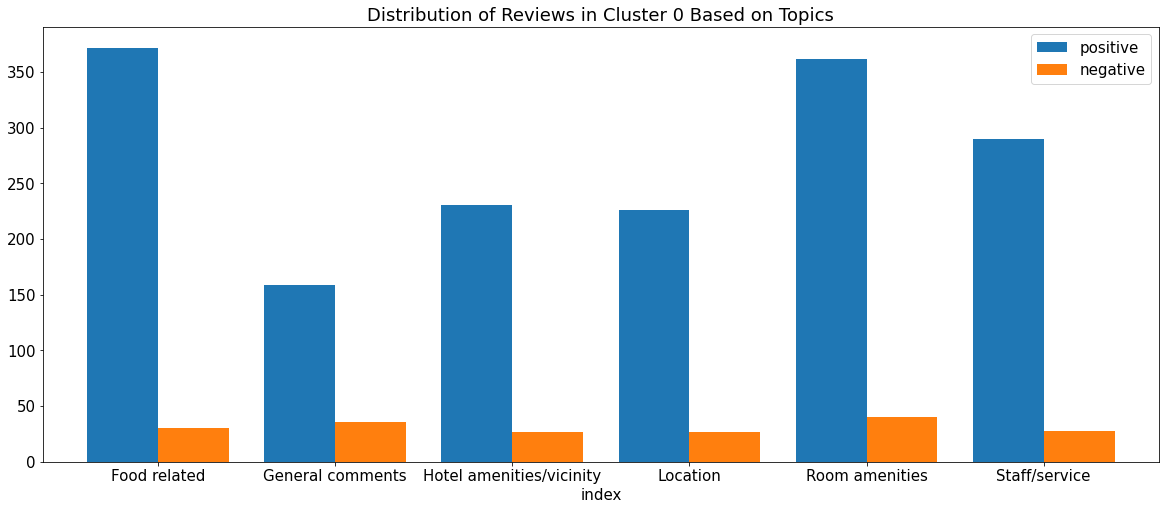

In [ ]:
# plot distribution of words based on topics
df_topic_sentiment_cluster_0.sort_values("index").plot(x="index", y=["positive", "negative"], kind="bar", width = 0.8, rot = 0)

# adjust plot settings, add labels, add title
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams.update({'font.size': 15})
plt.title('Distribution of Reviews in Cluster 0 Based on Topics')

## **4.2 Cluster 1**

Text(0.5, 1.0, 'Common Words in Cluster 1')

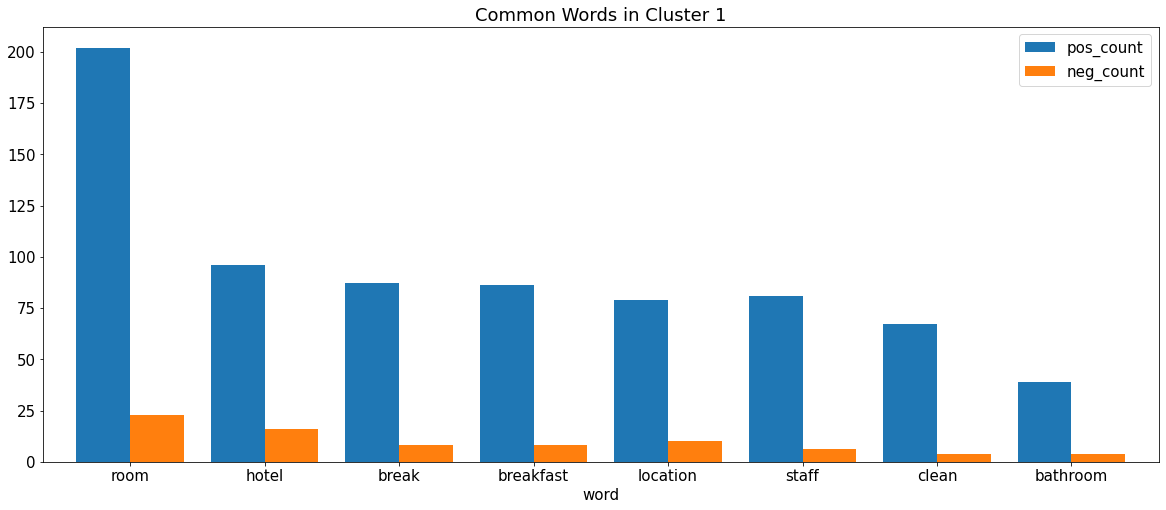

In [ ]:
# plot common words in the cluster
df_common_words_cluster_1.iloc[:8].plot(x="word", y=["pos_count", "neg_count"], kind="bar", width = 0.8, rot = 0)

# adjust plot settings, add labels, add title
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams.update({'font.size': 15})
plt.title('Common Words in Cluster 1')

Text(0.5, 1.0, 'Distribution of Reviews in Cluster 1 Based on Topics')

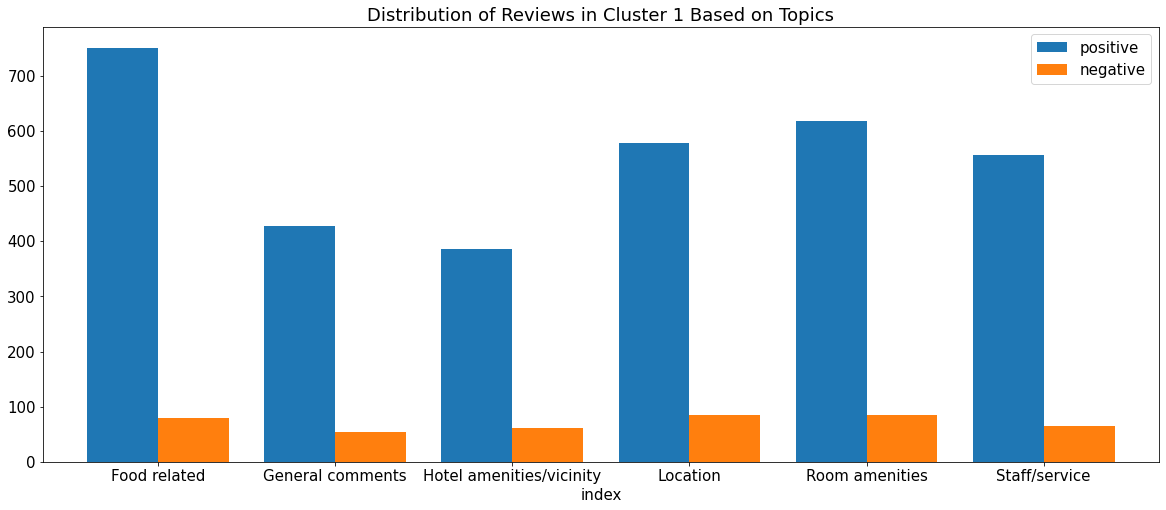

In [ ]:
# plot distribution of words based on topics
df_topic_sentiment_cluster_1.sort_values("index").plot(x="index", y=["positive", "negative"], kind="bar", width = 0.8, rot = 0)

# adjust plot settings, add labels, add title
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams.update({'font.size': 15})
plt.title('Distribution of Reviews in Cluster 1 Based on Topics')

## **4.3 Cluster 2**

Text(0.5, 1.0, 'Common Words in Cluster 2')

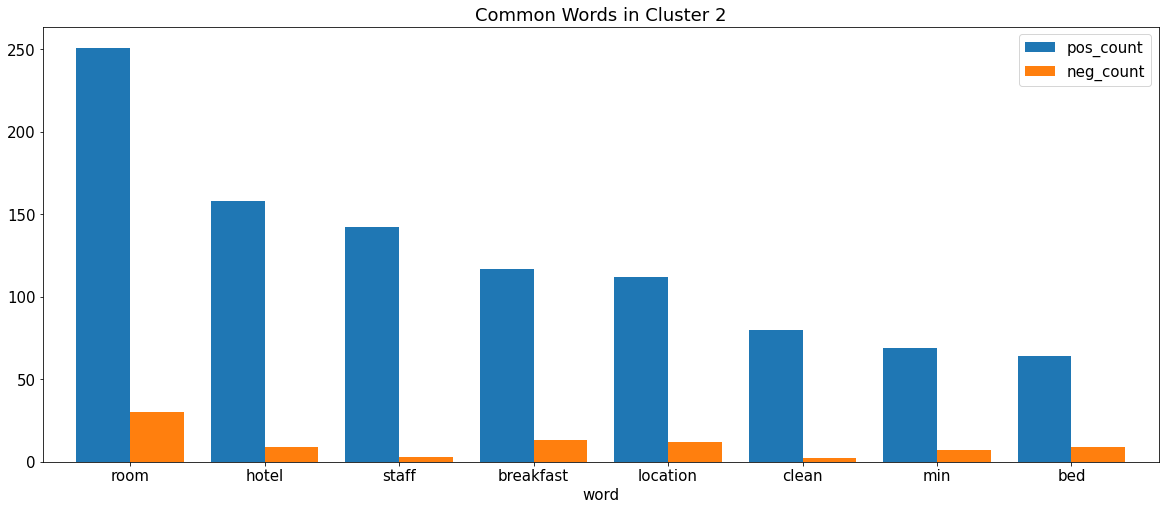

In [ ]:
# plot common words in the cluster
df_common_words_cluster_2.iloc[:8].plot(x="word", y=["pos_count", "neg_count"], kind="bar", width = 0.8, rot = 0)

# adjust plot settings, add labels, add title
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams.update({'font.size': 15})
plt.title('Common Words in Cluster 2')

Text(0.5, 1.0, 'Distribution of Reviews in Cluster 2 Based on Topics')

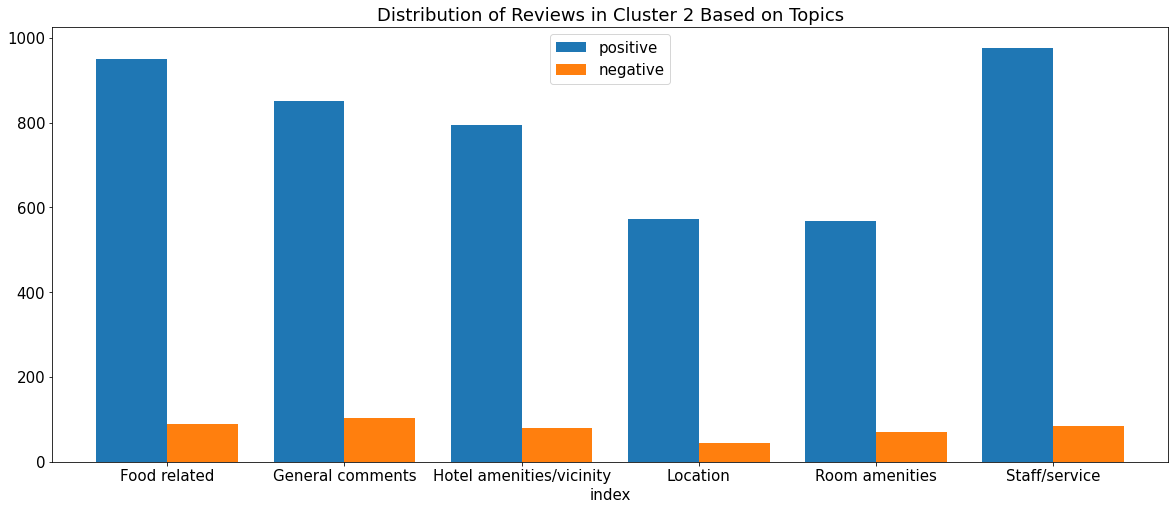

In [ ]:
# plot distribution of words based on topics
df_topic_sentiment_cluster_2.sort_values("index").plot(x="index", y=["positive", "negative"], kind="bar", width = 0.8, rot = 0)

# adjust plot settings, add labels, add title
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams.update({'font.size': 15})
plt.title('Distribution of Reviews in Cluster 2 Based on Topics')

## **4.4 Cluster 3**

Text(0.5, 1.0, 'Common Words in Cluster 3')

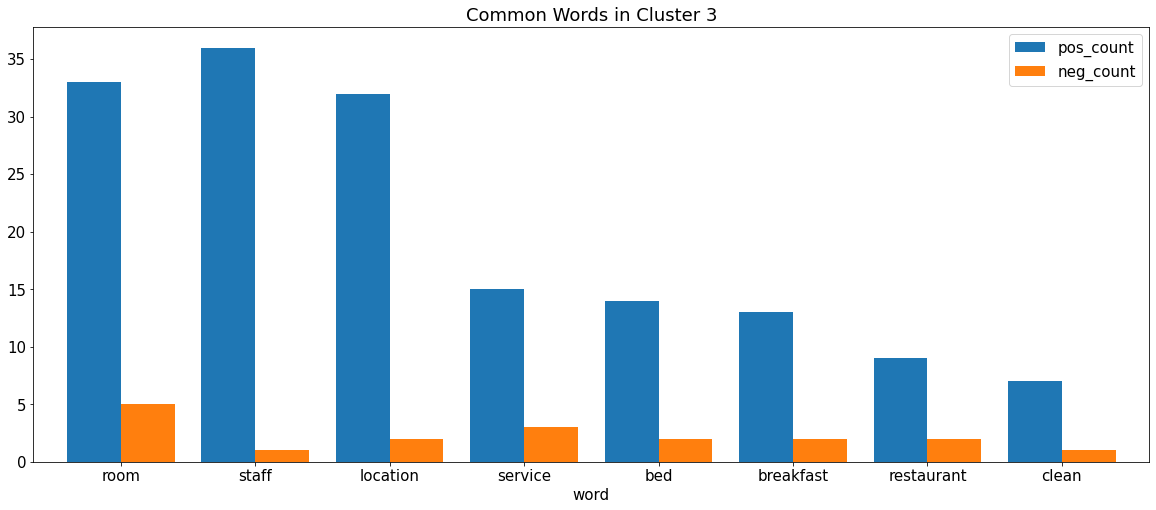

In [ ]:
# plot common words in the cluster
df_common_words_cluster_3.iloc[:8].plot(x="word", y=["pos_count", "neg_count"], kind="bar", width = 0.8, rot = 0)

# adjust plot settings, add labels, add title
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams.update({'font.size': 15})
plt.title('Common Words in Cluster 3')

Text(0.5, 1.0, 'Distribution of Reviews in Cluster 3 Based on Topics')

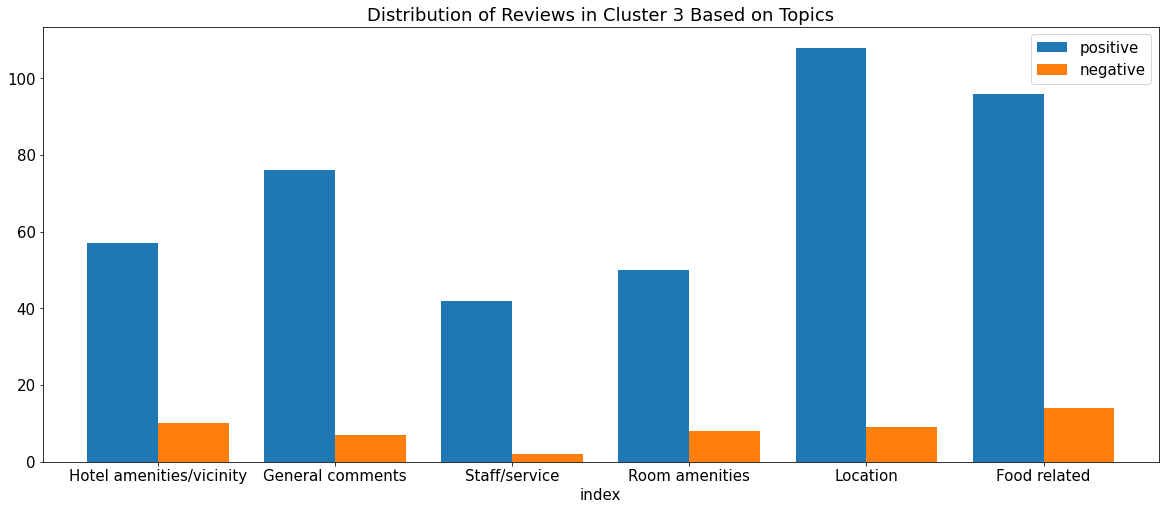

In [ ]:
# plot distribution of words based on topics
df_topic_sentiment_cluster_3.plot(x="index", y=["positive", "negative"], kind="bar", width = 0.8, rot = 0)

# adjust plot settings, add labels, add title
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams.update({'font.size': 15})
plt.title('Distribution of Reviews in Cluster 3 Based on Topics')

## **4.5 Overall**

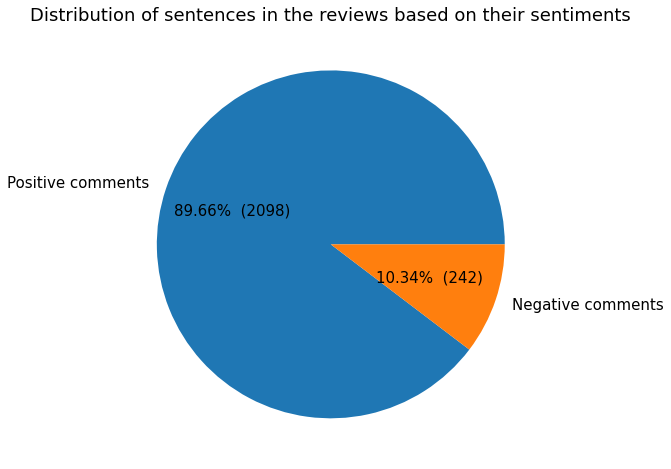

In [ ]:
nested_sentiment = df_review['sentences_sentiments']
#the following line will unlist the nested sentiments
sentiment = list(chain.from_iterable(nested_sentiment))
temp = [x == "Positive" for x in sentiment]
positive = sum(temp)
negative = len(temp) - positive

y = np.array([positive, negative])
mylabels = ["Positive comments", "Negative comments"]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.pie(y, labels = mylabels, autopct = make_autopct(y))
plt.title("Distribution of sentences in the reviews based on their sentiments")
plt.show() 

# **5) INSIGHT**

### *Import necessary packages & Define useful functions*



In [ ]:
import spacy
nlp = spacy.load('en')

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.append('the')

In [ ]:
#returns us all the rows of review sentences that have been assigned to a certain topic and cluster
def getting_descriptions_wo_filtering_by_polarity(word_cluster_df, topic):
    temp = []
    for index, row in word_cluster_df.iterrows():
        pos_desc, neg_desc, topics = row['pos_desc'], row['neg_desc'], row['topics']
        if topic in topics:
            temp += pos_desc
            temp += neg_desc
    return temp

In [ ]:
#returns us the top_n most frequently appearing nouns present from the sentences in a certain topic and cluster
def common_noun(word_cluster_df, topic, top_n):
    dictionary = {}
    for sentence in getting_descriptions_wo_filtering_by_polarity(word_cluster_df, topic):
        sentence = nlp(sentence)
        for i, token in enumerate(sentence):
            if token.pos_ in ('NOUN'):
                if token.text in dictionary.keys():
                    dictionary[token.text] += 1
                else:
                    dictionary[token.text] = 1
    return sorted(dictionary.items(), key=lambda item: item[1], reverse = True)[0:top_n]


In [ ]:
#returns us the noun_chunks from the review sentences that contain the specified "word" as well as desired polarity
def getting_relevant_sentence(word_cluster_df, polarity, topic, word):
    sentences = []
    for sentence in getting_descriptions_wo_filtering_by_polarity(word_cluster_df, topic): #gets all the reviews with the specific word in it
        if word in sentence:
            sentences.append(sentence)
    ans = []
    for text in sentences:
        doc = nlp(text)
        for noun in doc.noun_chunks:
            if (word in noun.text) and (analysis(sid.polarity_scores(noun.text)["compound"]) == polarity): #keeps only the noun_chunks that have the intended polarity score and the specified word
                ans.append(noun.text)
    ans1 = {item:ans.count(item) for item in ans}
    ans1 = sorted(ans1.items(), key = lambda item: item[1], reverse = True)
    return ans1

In [ ]:
#returns us the word count description of noun from the specified topic and cluster based on type of descriptions (positive or negative phrases)
def create_df_word_count(df_topic, type_of_review, cluster_n):
    result = pd.DataFrame(df_topic[type_of_review][cluster_n], columns =['desc', 'count'])
    
    #remove noun from desc
    noun = df_topic['Noun'][cluster_n]
    result['desc'] = result['desc'].str.replace(noun, '')

    # remove nan values
    result.dropna(subset = ["desc"], inplace=True)

    # remove useless words
    to_remove = [',the', '>']
    result['desc'] = result['desc'].apply(lambda x: ' '.join([word for word in x.split() if word not in (to_remove)]))

    # remove stopwords
    result['desc'] =result['desc'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    # remove empty desc
    result = result[result.desc != '']

    return result

## **5.1 Prominent nouns and their description**

### **Location**

In [ ]:
location = []
#the nouns are decided by looking at the output of the common_noun function. The most frequently occuring noun that describes this topic will be chosen
location.append(["Cluster 0", "parking", getting_relevant_sentence(df_common_words_cluster_0, "Positive", "Location", "parking"), getting_relevant_sentence(df_common_words_cluster_0, "Negative", "Location", "parking")])
location.append(["Cluster 1", "station", getting_relevant_sentence(df_common_words_cluster_1, "Positive", "Location", "station"), getting_relevant_sentence(df_common_words_cluster_1, "Negative", "Location", "station")])
location.append(["Cluster 2", "station", getting_relevant_sentence(df_common_words_cluster_2, "Positive", "Location", "station"), getting_relevant_sentence(df_common_words_cluster_2, "Negative", "Location", "station")])

df_location = pd.DataFrame(location, columns = ["Cluster No.", "Noun", "+ve phrases", "-ve phrases"])
df_location

,Cluster No.,Noun,+ve phrases,-ve phrases
0,Cluster 0,parking,"[(parking, 23), (the parking, 7), (secure park...","[(no reserved parking, 3)]"
1,Cluster 1,station,"[(metro station, 5), (the roger metro station,...",[]
2,Cluster 2,station,"[(the train station, 29), (the station, 10), (...",[]


### **Food related**

In [ ]:
food = []
#the nouns are decided by looking at the output of the common_noun function. The most frequently occuring noun that describes this topic will be chosen
food.append(["Cluster 0", "breakfast", getting_relevant_sentence(df_common_words_cluster_0, "Positive", "Food related", "breakfast"), getting_relevant_sentence(df_common_words_cluster_0, "Negative", "Food related", "breakfast")])
food.append(["Cluster 1", "breakfast", getting_relevant_sentence(df_common_words_cluster_1, "Positive", "Food related", "breakfast"), getting_relevant_sentence(df_common_words_cluster_1, "Negative", "Food related", "breakfast")])
food.append(["Cluster 2", "breakfast", getting_relevant_sentence(df_common_words_cluster_2, "Positive", "Food related", "breakfast"), getting_relevant_sentence(df_common_words_cluster_2, "Negative", "Food related", "breakfast")])

df_food = pd.DataFrame(food, columns = ["Cluster No.", "Noun", "+ve phrases", "-ve phrases"])
df_food

,Cluster No.,Noun,+ve phrases,-ve phrases
0,Cluster 0,breakfast,"[(breakfast, 31), (the breakfast, 20), (delici...",[]
1,Cluster 1,breakfast,"[(breakfast, 72), (the breakfast, 40), (very g...",[]
2,Cluster 2,breakfast,"[(breakfast, 95), (the breakfast, 38), (good b...","[(such a poor breakfast, 2), (no breakfast, 2)..."


### **Room amenities**

In [ ]:
room = []
#the nouns are decided by looking at the output of the common_noun function. The most frequently occuring noun that describes this topic will be chosen
room.append(["Cluster 0", "bed", getting_relevant_sentence(df_common_words_cluster_0, "Positive", "Room amenities", "bed"), getting_relevant_sentence(df_common_words_cluster_0, "Negative", "Room amenities", "bed")])
room.append(["Cluster 1", "bathroom", getting_relevant_sentence(df_common_words_cluster_1, "Positive", "Room amenities", "bathroom"), getting_relevant_sentence(df_common_words_cluster_1, "Negative", "Room amenities", "bathroom")])
room.append(["Cluster 2", "bathroom", getting_relevant_sentence(df_common_words_cluster_2, "Positive", "Room amenities", "bathroom"), getting_relevant_sentence(df_common_words_cluster_2, "Negative", "Room amenities", "bathroom")])

df_room = pd.DataFrame(room, columns = ["Cluster No.", "Noun", "+ve phrases", "-ve phrases"])
df_room

,Cluster No.,Noun,+ve phrases,-ve phrases
0,Cluster 0,bed,"[(the bed, 20), (bed, 14), (the beds, 10), (be...",[]
1,Cluster 1,bathroom,"[(the bathroom, 26), (bathroom, 12), (bathroom...","[(no bathroom, 5), (carpet worn outbathroom, 2..."
2,Cluster 2,bathroom,"[(the bathroom, 66), (bathroom, 49), (fine bat...",[]


### **Staff/service**

In [ ]:
staff = []
#the nouns are decided by looking at the output of the common_noun function. The most frequently occuring noun that describes this topic will be chosen
staff.append(["Cluster 0", "staff", getting_relevant_sentence(df_common_words_cluster_0, "Positive", "Staff/service", "staff"), getting_relevant_sentence(df_common_words_cluster_0, "Negative", "Staff/service", "staff")])
staff.append(["Cluster 1", "staff", getting_relevant_sentence(df_common_words_cluster_1, "Positive", "Staff/service", "staff"), getting_relevant_sentence(df_common_words_cluster_1, "Negative", "Staff/service", "staff")])
staff.append(["Cluster 2", "staff", getting_relevant_sentence(df_common_words_cluster_2, "Positive", "Staff/service", "staff"), getting_relevant_sentence(df_common_words_cluster_2, "Negative", "Staff/service", "staff")])

df_service = pd.DataFrame(staff, columns = ["Cluster No.", "Noun", "+ve phrases", "-ve phrases"])
df_service

,Cluster No.,Noun,+ve phrases,-ve phrases
0,Cluster 0,staff,"[(the staff, 16), (staff, 16), (,the staff, 4)...",[]
1,Cluster 1,staff,"[(the staff, 21), (friendly staff, 7), (staff,...",[]
2,Cluster 2,staff,"[(the staff, 78), (staff, 68), (friendly staff...",[]


### **Hotel amenities/vicinity**

In [ ]:
hotel = []
#the nouns are decided by looking at the output of the common_noun function. The most frequently occuring noun that describes this topic will be chosen
hotel.append(["Cluster 0", "pool", getting_relevant_sentence(df_common_words_cluster_0, "Positive", "Hotel amenities/vicinity", "pool"), getting_relevant_sentence(df_common_words_cluster_0, "Negative", "Hotel amenities/vicinity", "pool")])
hotel.append(["Cluster 1", "bathroom", getting_relevant_sentence(df_common_words_cluster_1, "Positive", "Hotel amenities/vicinity", "bathroom"), getting_relevant_sentence(df_common_words_cluster_1, "Negative", "Hotel amenities/vicinity", "bathroom")])
hotel.append(["Cluster 2", "location", getting_relevant_sentence(df_common_words_cluster_2, "Positive", "Hotel amenities/vicinity", "location"), getting_relevant_sentence(df_common_words_cluster_2, "Negative", "Hotel amenities/vicinity", "location")])

df_hotel = pd.DataFrame(hotel, columns = ["Cluster No.", "Noun", "+ve phrases", "-ve phrases"])
df_hotel

,Cluster No.,Noun,+ve phrases,-ve phrases
0,Cluster 0,pool,"[(swimming pool, 11), (the swimming pool, 9), ...",[]
1,Cluster 1,bathroom,"[(bathroom, 6), (the bathroom, 4), (great bath...","[(no bathroom, 2), (carpet worn outbathroom, 2)]"
2,Cluster 2,location,"[(location, 68), (the location, 36), (,great l...","[(an awkward waist-height location, 2)]"


### **General comments**

In [ ]:
general = []
#the nouns are decided by looking at the output of the common_noun function. The most frequently occuring noun that describes this topic will be chosen
general.append(["Cluster 0", "hotel", getting_relevant_sentence(df_common_words_cluster_0, "Positive", "General comments", "hotel"), getting_relevant_sentence(df_common_words_cluster_0, "Negative", "General comments", "hotel")])
general.append(["Cluster 1", "hotel", getting_relevant_sentence(df_common_words_cluster_1, "Positive", "General comments", "hotel"), getting_relevant_sentence(df_common_words_cluster_1, "Negative", "General comments", "hotel")])
general.append(["Cluster 2", "room", getting_relevant_sentence(df_common_words_cluster_2, "Positive", "General comments", "room"), getting_relevant_sentence(df_common_words_cluster_2, "Negative", "General comments", "room")])

df_general = pd.DataFrame(general, columns = ["Cluster No.", "Noun", "+ve phrases", "-ve phrases"])
df_general

,Cluster No.,Noun,+ve phrases,-ve phrases
0,Cluster 0,hotel,"[(the hotel, 55), (hotel, 17), (this hotel, 11...",[]
1,Cluster 1,hotel,"[(the hotel, 38), (hotel, 8), (the same hotel,...",[]
2,Cluster 2,room,"[(the room, 118), (room, 56), (the bathroom, 2...","[(a lower standard room, 2), (old, sad hotel r..."


## **5.2 Visualisation**

### **Location**

#### **Cluster 0**

**Positive**

In [ ]:
# parking
df_location_cluster_0_pos = create_df_word_count(df_location, '+ve phrases', 0)
#df_location_cluster_0_pos


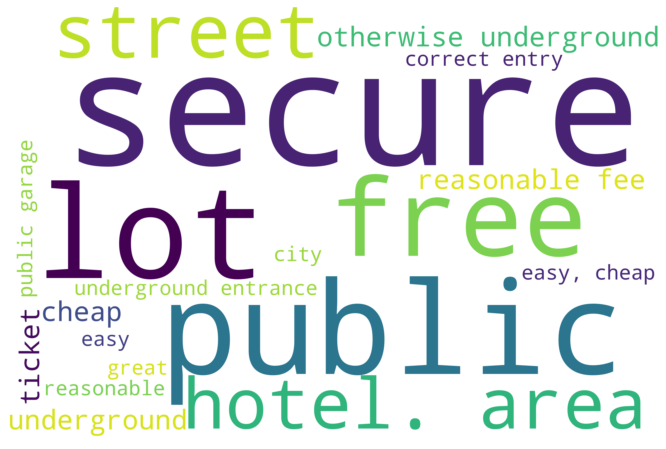

In [ ]:
d = {}
for a, x in df_location_cluster_0_pos.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Negative**

In [ ]:
df_location_cluster_0_neg = create_df_word_count(df_location, '-ve phrases', 0)
#df_location_cluster_0_neg

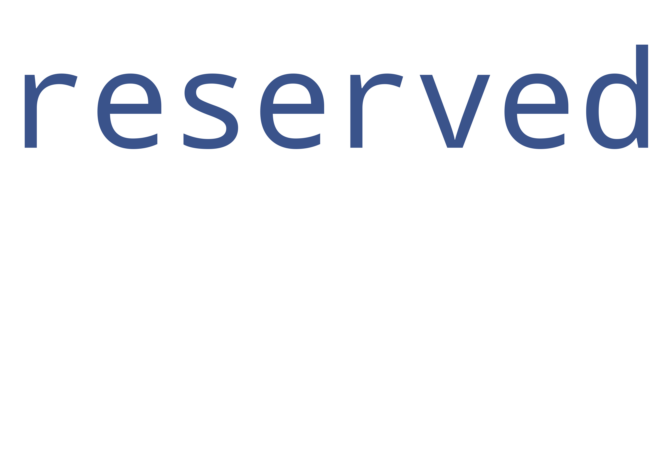

In [ ]:
d = {}
for a, x in df_location_cluster_0_neg.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### **Cluster 1**

**Positive**

In [ ]:
# parking
df_location_cluster_1_pos = create_df_word_count(df_location, '+ve phrases', 1)
#df_location_cluster_1_pos


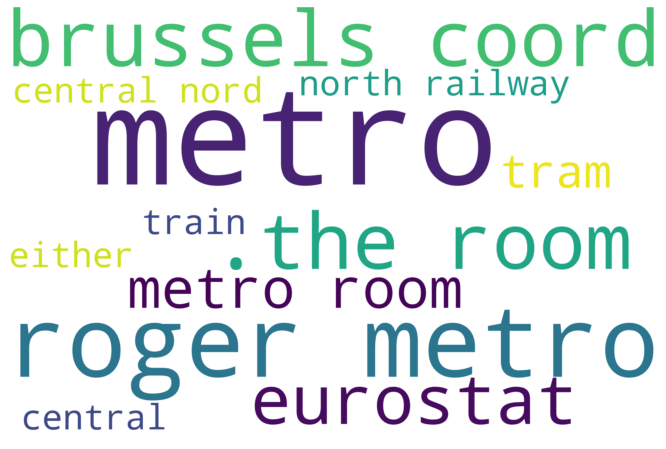

In [ ]:
d = {}
for a, x in df_location_cluster_1_pos.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Negative**

In [ ]:
df_location_cluster_1_neg = create_df_word_count(df_location, '-ve phrases', 1)
# df_location_cluster_1_neg

In [ ]:
# d = {}
# for a, x in df_location_cluster_1_neg.values:
#     d[a] = x

# wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
# wordcloud.generate_from_frequencies(frequencies=d)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

#### **Cluster 2**

**Positive**

In [ ]:
df_location_cluster_2_pos = create_df_word_count(df_location, '+ve phrases', 2)
# df_location_cluster_2_pos


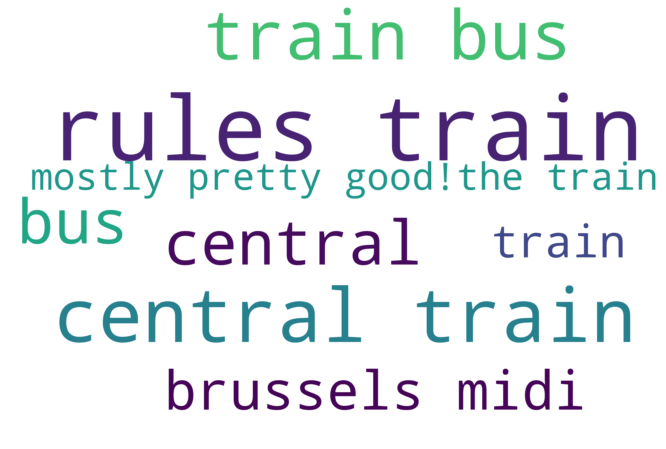

In [ ]:
d = {}
for a, x in df_location_cluster_2_pos.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Negative**

In [ ]:
df_location_cluster_2_neg = create_df_word_count(df_location, '-ve phrases', 2)
# df_location_cluster_2_neg

,desc,count


In [ ]:
# d = {}
# for a, x in df_location_cluster_0_neg.values:
#     d[a] = x

# wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
# wordcloud.generate_from_frequencies(frequencies=d)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

### **Food Related**

#### **Cluster 0**

**Positive**

In [ ]:
# breakfast
df_food_cluster_0_pos = create_df_word_count(df_food, '+ve phrases', 0)
#df_food_cluster_0_pos

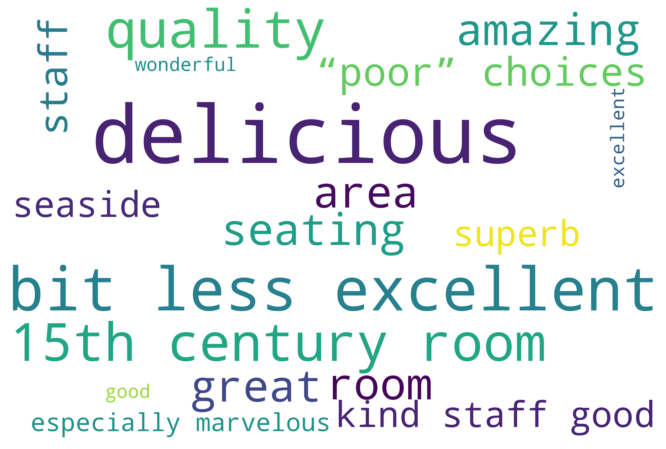

In [ ]:
d = {}
for a, x in df_food_cluster_0_pos.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Negative**

In [ ]:
df_food_cluster_0_neg = create_df_word_count(df_food, '-ve phrases', 0)
# df_food_cluster_0_neg

In [ ]:
# d = {}
# for a, x in df_location_cluster_0_neg.values:
#     d[a] = x

# wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
# wordcloud.generate_from_frequencies(frequencies=d)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

#### **Cluster 1**

**Positive**

In [ ]:
df_food_cluster_1_pos = create_df_word_count(df_food, '+ve phrases', 1)
#df_food_cluster_1_pos

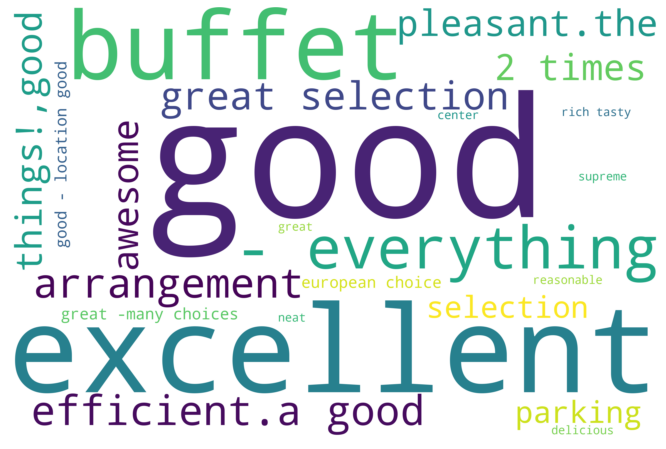

In [ ]:
d = {}
for a, x in df_food_cluster_1_pos.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Negative**

In [ ]:
df_food_cluster_0_neg = create_df_word_count(df_food, '-ve phrases', 0)
# df_food_cluster_0_neg

In [ ]:
# d = {}
# for a, x in df_food_cluster_0_neg.values:
#     d[a] = x

# wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
# wordcloud.generate_from_frequencies(frequencies=d)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

#### **Cluster 2**

**Positive**

In [ ]:
df_food_cluster_2_pos = create_df_word_count(df_food, '+ve phrases', 2)
#df_food_cluster_2_pos

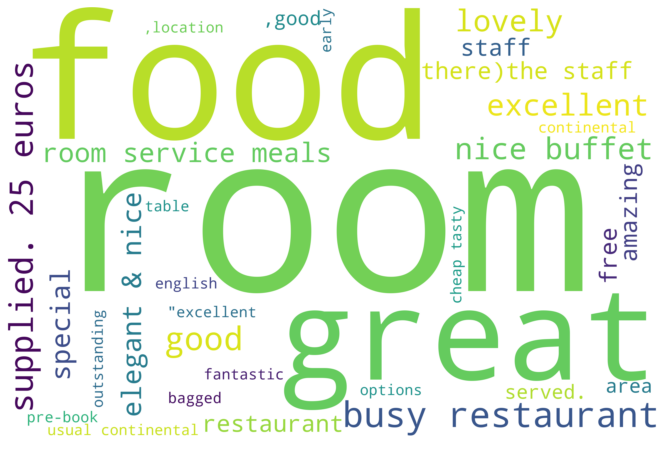

In [ ]:
d = {}
for a, x in df_food_cluster_2_pos.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Negative**

In [ ]:
df_food_cluster_2_neg = create_df_word_count(df_food, '-ve phrases', 2)
# df_food_cluster_2_neg

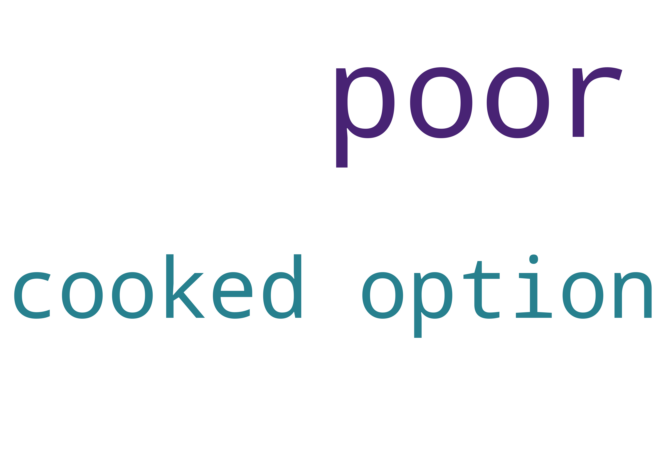

In [ ]:
d = {}
for a, x in df_food_cluster_2_neg.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### **Room Amenities**

#### **Cluster 0**

**Positive**

In [ ]:
# breakfast
df_room_cluster_0_pos = create_df_word_count(df_room, '+ve phrases', 0)
#df_room_cluster_0_pos

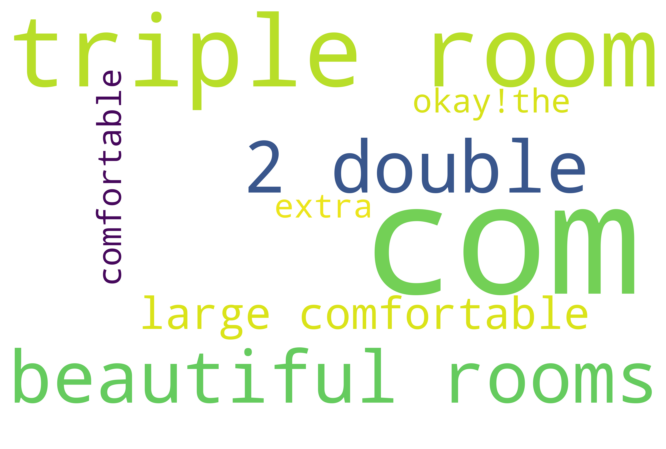

In [ ]:
d = {}
for a, x in df_room_cluster_0_pos.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Negative**

In [ ]:
df_room_cluster_0_neg = create_df_word_count(df_room, '-ve phrases', 0)
# df_room_cluster_0_neg

,desc,count


In [ ]:
# d = {}
# for a, x in df_room_cluster_0_neg.values:
#     d[a] = x

# wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
# wordcloud.generate_from_frequencies(frequencies=d)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

#### **Cluster 1**

**Positive**

In [ ]:
df_room_cluster_1_pos = create_df_word_count(df_room, '+ve phrases', 1)
#df_room_cluster_1_pos

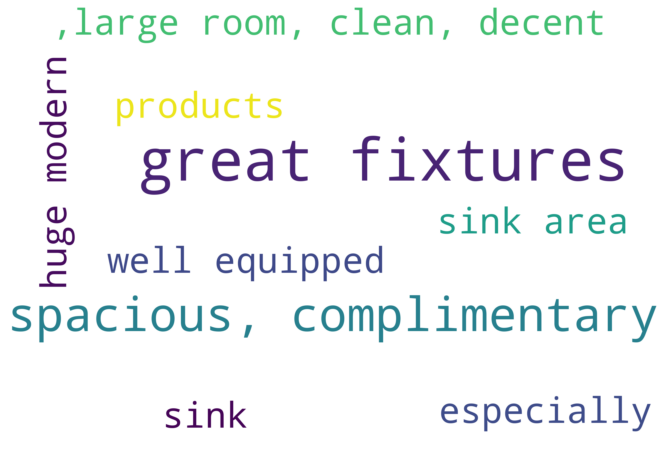

In [ ]:
d = {}
for a, x in df_room_cluster_1_pos.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Negative**

In [ ]:
df_room_cluster_1_neg = create_df_word_count(df_room, '-ve phrases', 1)
df_room_cluster_1_neg

,desc,count
1,carpet worn,2
2,"loose, dirty disgusting",1


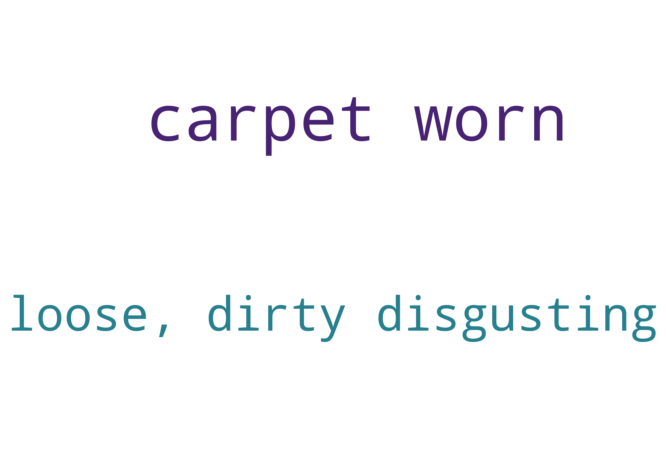

In [ ]:
d = {}
for a, x in df_room_cluster_1_neg.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### **Cluster 2**

**Positive**

In [ ]:
df_room_cluster_2_pos = create_df_word_count(df_room, '+ve phrases', 2)
#df_room_cluster_2_pos

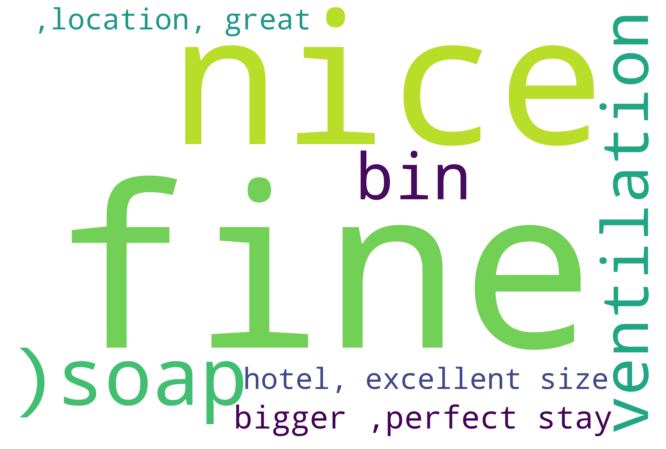

In [ ]:
d = {}
for a, x in df_room_cluster_2_pos.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Negative**

In [ ]:
df_room_cluster_2_neg = create_df_word_count(df_room, '-ve phrases', 2)
# df_room_cluster_2_neg

,desc,count


In [ ]:
# d = {}
# for a, x in df_room_cluster_2_neg.values:
#     d[a] = x

# wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
# wordcloud.generate_from_frequencies(frequencies=d)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

### **Staff/service**

#### **Cluster 0**

**Positive**

In [ ]:
df_service_cluster_0_pos = create_df_word_count(df_service, '+ve phrases', 0)
#df_service_cluster_0_pos

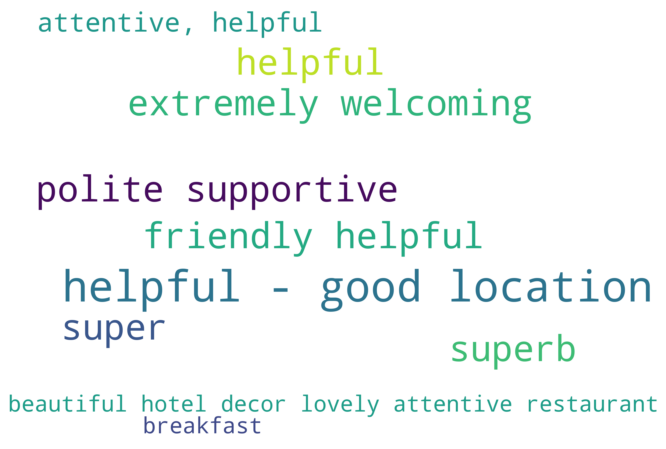

In [ ]:
d = {}
for a, x in df_service_cluster_0_pos.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Negative**

In [ ]:
df_service_cluster_0_neg = create_df_word_count(df_service, '-ve phrases', 0)
# df_service_cluster_0_neg

,desc,count


In [ ]:
# d = {}
# for a, x in df_service_cluster_0_neg.values:
#     d[a] = x

# wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
# wordcloud.generate_from_frequencies(frequencies=d)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

#### **Cluster 1**

**Positive**

In [ ]:
df_service_cluster_1_pos = create_df_word_count(df_service, '+ve phrases', 1)
#df_service_cluster_1_pos

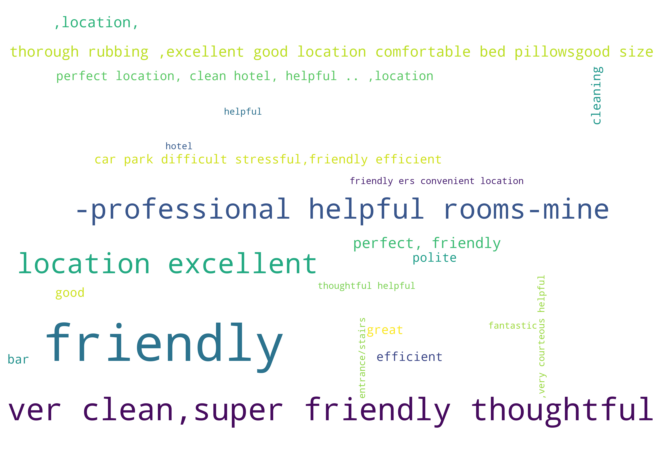

In [ ]:
d = {}
for a, x in df_service_cluster_1_pos.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Negative**

In [ ]:
df_service_cluster_1_neg = create_df_word_count(df_service, '-ve phrases', 1)
# df_service_cluster_1_neg

In [ ]:
# d = {}
# for a, x in df_service_cluster_1_neg.values:
#     d[a] = x

# wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
# wordcloud.generate_from_frequencies(frequencies=d)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

#### **Cluster 2**

**Positive**

In [ ]:
df_service_cluster_2_pos = create_df_word_count(df_service, '+ve phrases', 2)
#df_service_cluster_2_pos

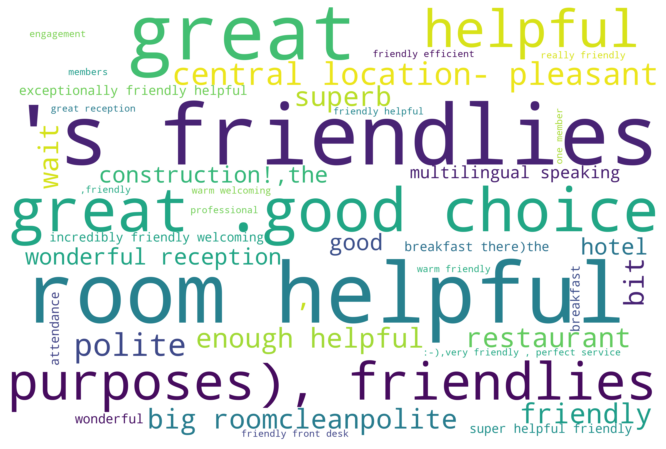

In [ ]:
d = {}
for a, x in df_service_cluster_2_pos.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Negative**

In [ ]:
df_service_cluster_2_neg = create_df_word_count(df_service, '-ve phrases', 2)
# df_service_cluster_2_neg

In [ ]:
# d = {}
# for a, x in df_service_cluster_2_neg.values:
#     d[a] = x

# wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
# wordcloud.generate_from_frequencies(frequencies=d)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

### **Hotel Amenities/Vicinity**

#### **Cluster 0**

**Positive**

In [ ]:
df_hotel_cluster_0_pos = create_df_word_count(df_hotel, '+ve phrases', 0)
#df_hotel_cluster_0_pos

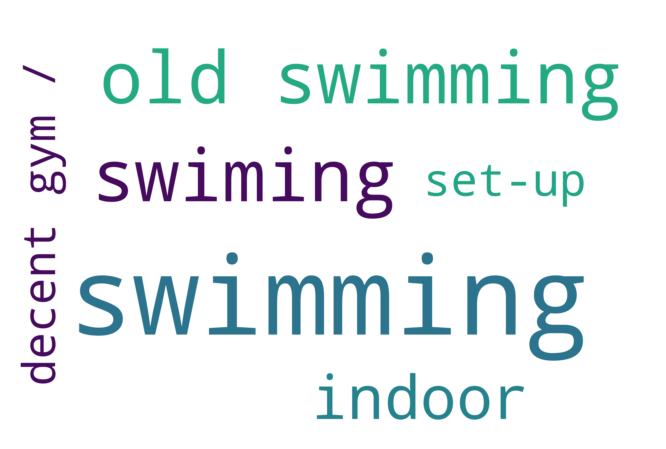

In [ ]:
d = {}
for a, x in df_hotel_cluster_0_pos.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Negative**

In [ ]:
df_hotel_cluster_0_neg = create_df_word_count(df_hotel, '-ve phrases', 0)
# df_hotel_cluster_0_neg

,desc,count


In [ ]:
# d = {}
# for a, x in df_hotel_cluster_0_neg.values:
#     d[a] = x

# wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
# wordcloud.generate_from_frequencies(frequencies=d)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

#### **Cluster 1**

**Positive**

In [ ]:
df_hotel_cluster_1_pos = create_df_word_count(df_hotel, '+ve phrases', 1)
#df_hotel_cluster_1_pos

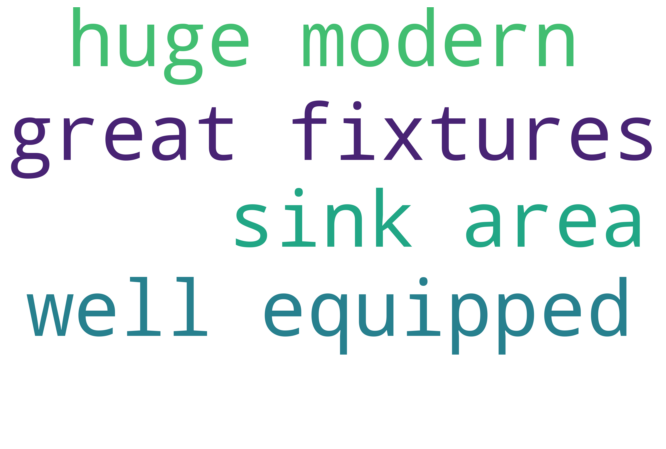

In [ ]:
d = {}
for a, x in df_hotel_cluster_1_pos.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Negative**

In [ ]:
df_hotel_cluster_1_neg = create_df_word_count(df_hotel, '-ve phrases', 1)
# df_hotel_cluster_1_neg

,desc,count
1,carpet worn,2


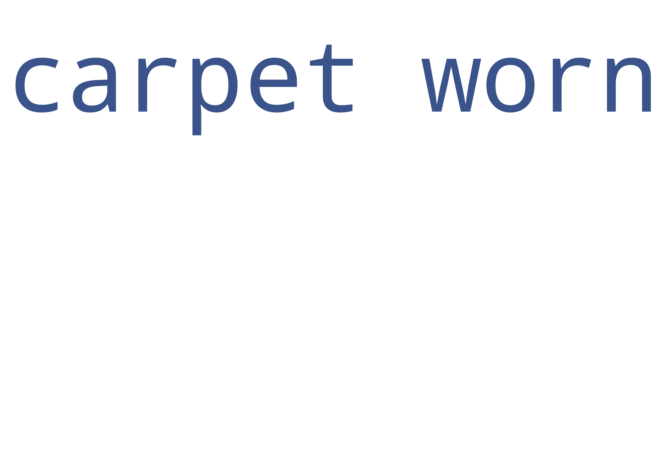

In [ ]:
d = {}
for a, x in df_hotel_cluster_1_neg.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### **Cluster 2**

**Positive**

In [ ]:
df_hotel_cluster_2_pos = create_df_word_count(df_hotel, '+ve phrases', 2)
#df_hotel_cluster_2_pos

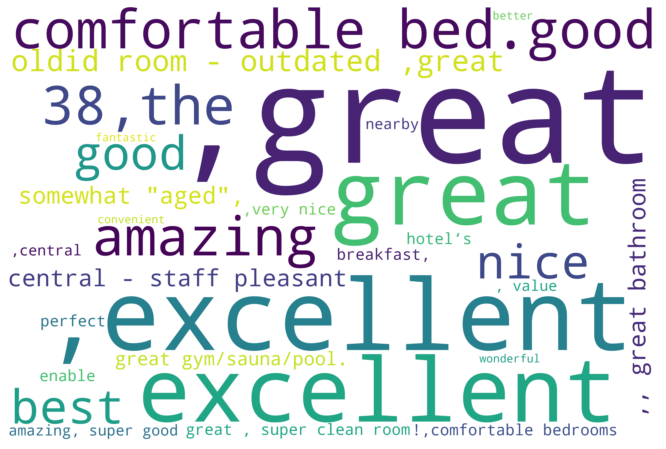

In [ ]:
d = {}
for a, x in df_hotel_cluster_2_pos.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Negative**

In [ ]:
df_hotel_cluster_2_neg = create_df_word_count(df_hotel, '-ve phrases', 2)
# df_hotel_cluster_2_neg

,desc,count
0,awkward waist-height,2


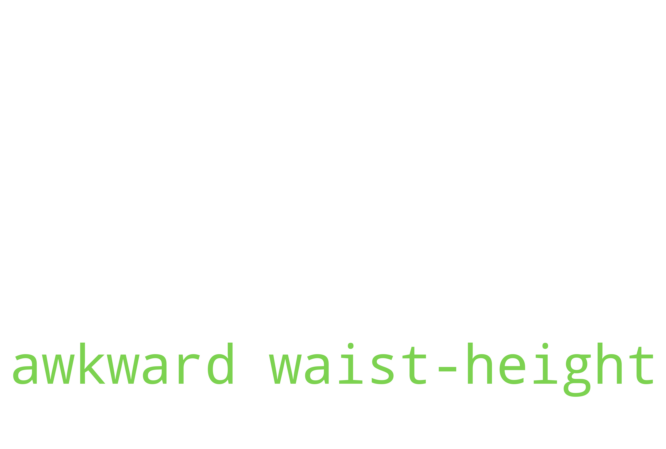

In [ ]:
d = {}
for a, x in df_hotel_cluster_2_neg.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### **General Comments**

#### **Cluster 0**

**Positive**

In [ ]:
df_general_cluster_0_pos = create_df_word_count(df_general, '+ve phrases', 0)
# df_general_cluster_0_pos

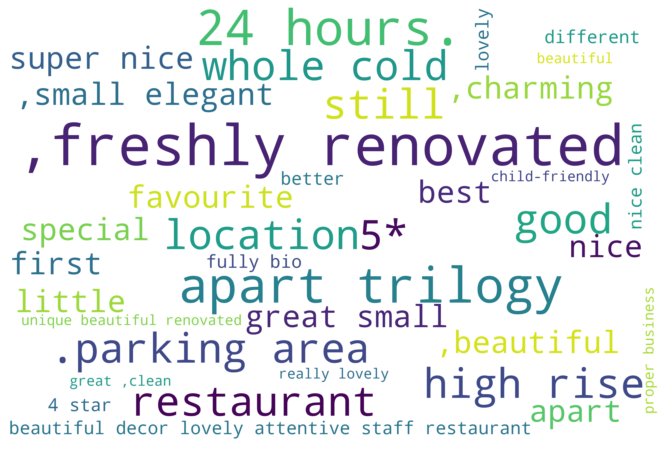

In [ ]:
d = {}
for a, x in df_general_cluster_0_pos.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Negative**

In [ ]:
df_general_cluster_0_neg = create_df_word_count(df_general, '-ve phrases', 0)
# df_general_cluster_0_neg

In [ ]:
# d = {}
# for a, x in df_general_cluster_0_neg.values:
#     d[a] = x

# wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
# wordcloud.generate_from_frequencies(frequencies=d)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

#### **Cluster 1**

**Positive**

In [ ]:
df_general_cluster_1_pos = create_df_word_count(df_general, '+ve phrases', 1)
#df_general_cluster_1_pos

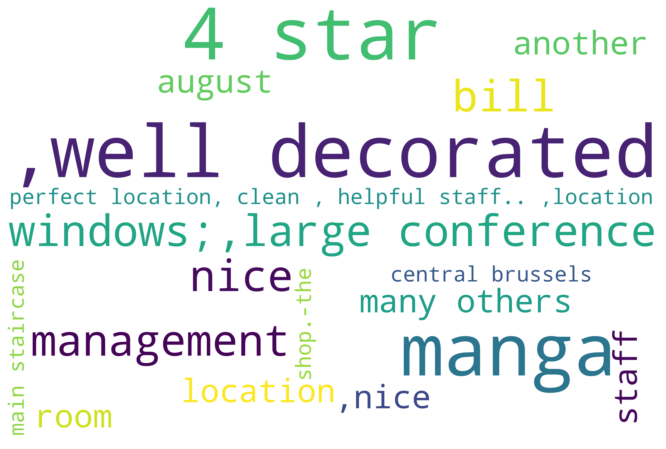

In [ ]:
d = {}
for a, x in df_general_cluster_1_pos.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Negative**

In [ ]:
df_general_cluster_1_neg = create_df_word_count(df_general, '-ve phrases', 1)
# df_general_cluster_1_neg

In [ ]:
# d = {}
# for a, x in df_general_cluster_1_neg.values:
#     d[a] = x

# wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
# wordcloud.generate_from_frequencies(frequencies=d)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

#### **Cluster 2**

**Positive**

In [ ]:
df_general_cluster_2_pos = create_df_word_count(df_general, '+ve phrases', 2)
#df_general_cluster_2_pos

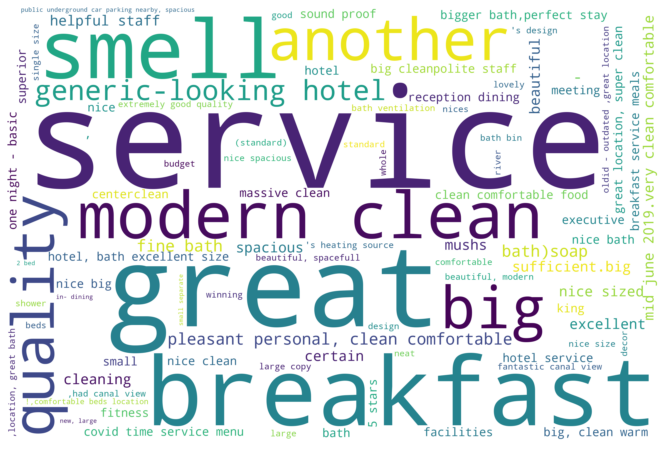

In [ ]:
d = {}
for a, x in df_general_cluster_2_pos.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Negative**

In [ ]:
df_general_cluster_2_neg = create_df_word_count(df_general, '-ve phrases', 2)
# df_general_cluster_2_neg

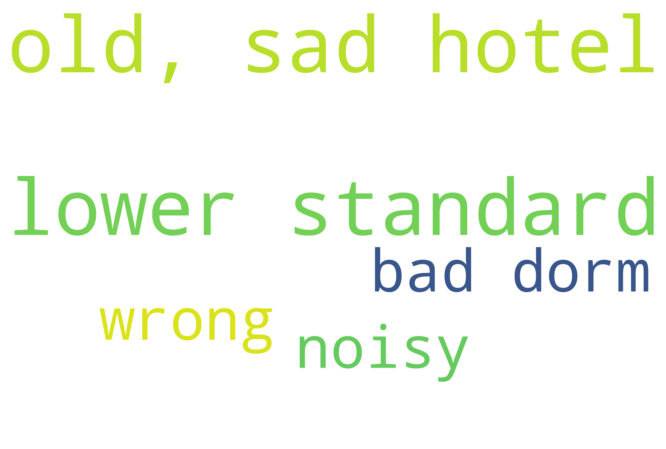

In [ ]:
d = {}
for a, x in df_general_cluster_2_neg.values:
    d[a] = x

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", collocations=False, stopwords = STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()